## PROCESS SATELLITE DATA TO MADE READY FOR ML MODEL

**The purpose** 
> Preprocess saellite data to made ready as input for ML model

<hr/> 

## 1-Import necessary package

In [1]:
import numpy as np
import rasterio
from rasterio import plot
import warnings
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os, glob, functools, fnmatch, requests,  io, shutil, tarfile, json
from tqdm import tqdm
from rasterio.merge import merge
from IPython.display import Image
warnings.filterwarnings('ignore')

<hr/> 

## 4-Slice RGB Image into small tiles

In [2]:
def get_tile_name_path(dst_dir:str, index:int):
    '''
    generating index specific tile name
    '''
    dst_tile_name = "{}_.tif".format(str(index).zfill(5))
    dst_tile_path = os.path.join(dst_dir, dst_tile_name)
    return dst_tile_name, dst_tile_path

def get_tile_transform(parent_transform, pixel_x:int,pixel_y:int):
    '''
    creating tile transform matrix from parent tif image
    '''
    crs_x = parent_transform.c + pixel_x * parent_transform.a
    crs_y = parent_transform.f + pixel_y * parent_transform.e
    tile_transform = rasterio.Affine(parent_transform.a, parent_transform.b, crs_x,
                                     parent_transform.d, parent_transform.e, crs_y)
    return tile_transform
    
def get_tile_profile(parent_tif:rasterio.io.DatasetReader, pixel_x:int, pixel_y:int):
    '''
    preparing tile profile
    '''
    tile_crs = parent_tif.crs
    tile_nodata = parent_tif.nodata if parent_tif.nodata is not None else 0
    tile_transform = get_tile_transform(parent_tif.transform, pixel_x, pixel_y)
    profile = dict(
                driver="GTiff",
                crs=tile_crs,
                nodata=tile_nodata,            
                transform=tile_transform
            )
    return profile

def generate_tiles(tif:rasterio.io.DatasetReader, size:int, dst_dir:str):
    i = 0
    for x in tqdm(range(0, tif.width, size)):
        for y in range(0, tif.height, size):
            # creating the tile specific profile
            profile = get_tile_profile(tif, x, y)
            # extracting the pixel data (couldnt understand as i dont think thats the correct way to pass the argument)
            tile_data = tif.read(window=((y, y + size), (x, x + size)),
                                 boundless=True, fill_value=profile['nodata'])[:3]
            i+=1
            dst_name, dst_tile_path = get_tile_name_path(dst_dir, i)
            c, h, w = tile_data.shape
            profile.update(
                height=h,
                width=w,
                count=c,
                dtype=tile_data.dtype,
            )
            with rasterio.open(dst_tile_path, "w", **profile) as dst:
                dst.write(tile_data)

In [5]:
#Set folder to save smail tile
RGB_path = "/Users/noeliaotero/Documents/Geo_analysis/data/RASTER_8.tif"
img = rasterio.open(RGB_path )
dst_image_dir = "/Users/noeliaotero/Documents/Geo_analysis/data/IMG_SLICE"

In [6]:
#We can change the size from 512 to 256, 224, ...
os.makedirs(dst_image_dir, exist_ok=True)

generate_tiles(img, 1024, dst_image_dir)

100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


In [7]:
# Count the number of files in the directory
num_files = len([f for f in os.listdir(dst_image_dir) if os.path.isfile(os.path.join(dst_image_dir, f))])

# Print the number of files
print("Number of files in the folder:", num_files)

Number of files in the folder: 36


<hr>

## 4a Visualizing the data for cloud cover

In [8]:
patch_files = os.listdir(dst_image_dir)

In [9]:
patches_list = []
for file in patch_files:
    path = os.path.join(dst_image_dir, file)
    patches_list.append(rasterio.open(path))

In [47]:
type(patches_list[0])

rasterio.io.DatasetReader

(35,
 <open DatasetReader name='/Users/noeliaotero/Documents/Geo_analysis/data/IMG_SLICE/00014_.tif' mode='r'>)

In [38]:
iter_patch = iter(enumerate(patches_list))

In [39]:
img_num, img_file = next(iter_patch, "Iteration complete")

In [25]:
import earthpy.plot as epp
def vispatch(iter_patch):
    img_num, img_file = next(iter_patch, "Iteration complete")
    if img_file != "Iteration complete":
        img_file.meta

        # plot.show_hist(img_file,bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title=f"Image {img_num} Histogram")
        # print(f"{img_num:05d}")

        rgb = np.array([img_file.read(1),img_file.read(2),img_file.read(3)]) 
        im = epp.plot_rgb(rgb, figsize=(10,10),stretch=True,str_clip=0.2, title=f"{img_num:05d}.tif")

        plt.show()

        rgb.shape
        img_file.close()
    else:
        print(img_file)

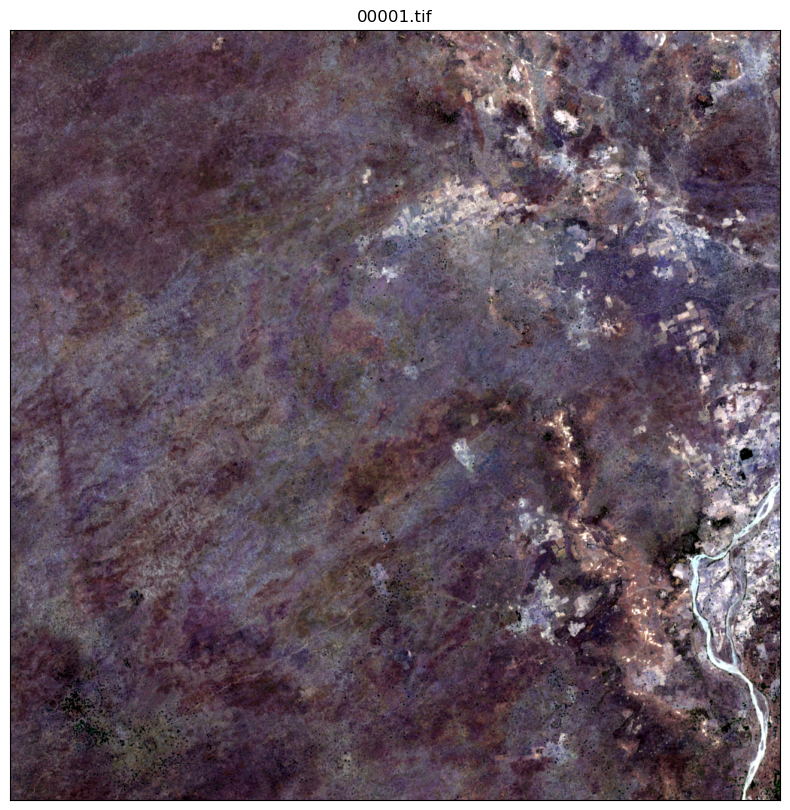

In [12]:
# Run cell as many times as required to step through and plot patches one at a time.

import earthpy.plot as epp

img_num, img_file = next(iter_patch, "Iteration complete")
if img_file != "Iteration complete":
    img_file.meta

    # plot.show_hist(img_file,bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title=f"Image {img_num} Histogram")
    # print(f"{img_num:05d}")

    rgb = np.array([img_file.read(1),img_file.read(2),img_file.read(3)]) 
    im = epp.plot_rgb(rgb, figsize=(10,10),stretch=True,str_clip=0.2, title=f"{img_num:05d}.tif")

    plt.show()

    rgb.shape
    img_file.close()
else:
    print(img_file)

<hr/> 

## 5- Filtering Unnecessary Data

In [22]:
tile_paths = os.listdir(dst_image_dir)

In [23]:
#tile_paths

In [24]:
search_criteria = "*.tif"
q = os.path.join(dst_image_dir , search_criteria)
print(q)

./IMG_SLICE/*.tif


In [25]:
# Get all of the quad tiles
quad_files = glob.glob(q)

In [1]:
#quad_files

In [27]:
src_files_to_mosaic = []

In [28]:
for f in quad_files:
  src = rasterio.open(f)
  src_files_to_mosaic.append(src)

In [31]:
# Create the mosaic
mosaic, out_trans = merge(src_files_to_mosaic)

In [32]:
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans
                  }
)

In [33]:
#The folder to save RGBNIR mosaic on a temporary folder 
temp_folder = r"./temp"
temp_file = "RASTER_17_merge.tif"
out_mosaic = os.path.join(temp_folder,temp_file )
# Write the mosaic to raster file
with rasterio.open(out_mosaic, "w", **out_meta) as dest:
    dest.write(mosaic)